<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will demonstrate how to perform Named Entity Recognition (NER) using TensorFlow, a popular deep learning framework. Named Entity Recognition is a critical task in natural language processing (NLP) that involves identifying and classifying entities, such as names of persons, organizations, locations, dates, and other significant terms, in unstructured text.

Data

In [1]:
import pickle

In [2]:
# conll 2003
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_train.pkl
!wget -nc https://lazyprogrammer.me/course_files/nlp/ner_test.pkl

File ‘ner_train.pkl’ already there; not retrieving.

File ‘ner_test.pkl’ already there; not retrieving.



In [3]:
with open("ner_train.pkl", 'rb') as f:
  corpus_train = pickle.load(f)

with open("ner_test.pkl", 'rb') as f:
  corpus_test = pickle.load(f)

In [4]:
train_inputs = []
train_targets = []
for lines in corpus_train:
  tokens = []
  target = []
  for token, tag in lines:
    tokens.append(token)
    target.append(tag)
  train_inputs.append(tokens)
  train_targets.append(target)

In [5]:
test_inputs = []
test_targets = []
for lines in corpus_test:
  tokens = []
  target = []
  for token, tag in lines:
    tokens.append(token)
    target.append(tag)
  test_inputs.append(tokens)
  test_targets.append(target)

In [6]:
len(train_inputs), len(test_inputs)

(12733, 2970)

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [8]:
# convert sentences to sequence
tokenizer = Tokenizer(lower=False, oov_token="UNK")
tokenizer.fit_on_texts(train_inputs)
train_inputs_int = tokenizer.texts_to_sequences(train_inputs)
test_inputs_int = tokenizer.texts_to_sequences(test_inputs)

In [9]:
# get word -> integer mapping
word2indx = tokenizer.word_index
V = len(word2indx)
print(V)

23299


In [10]:
#define function to flatten lists of list
def flatten_list(list_of_list):
  return [val for sublist in list_of_list for val in sublist]


In [11]:
all_train_target = set(flatten_list(train_targets))
all_train_target

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [12]:
all_test_target = set(flatten_list(test_targets))
all_test_target

{'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O'}

In [13]:
# Convert targets to sequences
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_targets_int = tag_tokenizer.texts_to_sequences(train_targets)
test_targets_int = tag_tokenizer.texts_to_sequences(test_targets)

# save for later
train_targets_int_unpadded = train_targets_int
test_targets_int_unpadded = test_targets_int

In [14]:
#find max document length
maxlen_train = max(len(x) for x in train_inputs)
maxlen_test = max(len(x) for x in test_inputs)
T = max(maxlen_train, maxlen_test)
T

113

In [15]:
#pad sequences
train_inputs_int = pad_sequences(train_inputs_int, T)
train_targets_int = pad_sequences(train_targets_int, T)
test_inputs_int = pad_sequences(test_inputs_int, T)
test_targets_int = pad_sequences(test_targets_int, T)


In [16]:
K = len(tag_tokenizer.word_index) + 1
K

10

In [18]:
#create a model
#embedding dimension
D = 50
i = Input(shape=(T,))
x = Embedding(V+ 1, D, mask_zero=True)(i)
x = GRU(32, return_sequences=True)(x)
x = Dense(K)(x)
model = Model(i,x)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 113)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 113, 50)           1165000   
                                                                 
 gru (GRU)                   (None, 113, 32)           8064      
                                                                 
 dense (Dense)               (None, 113, 10)           330       
                                                                 
Total params: 1,173,394
Trainable params: 1,173,394
Non-trainable params: 0
_________________________________________________________________


In [24]:
# compile
model.compile(
    optimizer = 'adam',
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [25]:
# fit and train
# 60s per epoch on CPU

print('Training model...')
r = model.fit(
  train_inputs_int,
  train_targets_int,
  epochs=10,
  validation_data=(test_inputs_int, test_targets_int)
)

Training model...
Epoch 1/10
398/398 [==============================] - 42s 93ms/step - loss: 0.6632 - accuracy: 0.8497 - val_loss: 0.4155 - val_accuracy: 0.8923
Epoch 2/10
398/398 [==============================] - 49s 124ms/step - loss: 0.2223 - accuracy: 0.9438 - val_loss: 0.2328 - val_accuracy: 0.9431
Epoch 3/10
398/398 [==============================] - 35s 87ms/step - loss: 0.0963 - accuracy: 0.9758 - val_loss: 0.1854 - val_accuracy: 0.9515
Epoch 4/10
398/398 [==============================] - 38s 95ms/step - loss: 0.0547 - accuracy: 0.9857 - val_loss: 0.1779 - val_accuracy: 0.9495
Epoch 5/10
398/398 [==============================] - 38s 94ms/step - loss: 0.0389 - accuracy: 0.9890 - val_loss: 0.1755 - val_accuracy: 0.9503
Epoch 6/10
398/398 [==============================] - 44s 111ms/step - loss: 0.0302 - accuracy: 0.9911 - val_loss: 0.1815 - val_accuracy: 0.9491
Epoch 7/10
398/398 [==============================] - 38s 96ms/step - loss: 0.0242 - accuracy: 0.9927 - val_loss: 0.

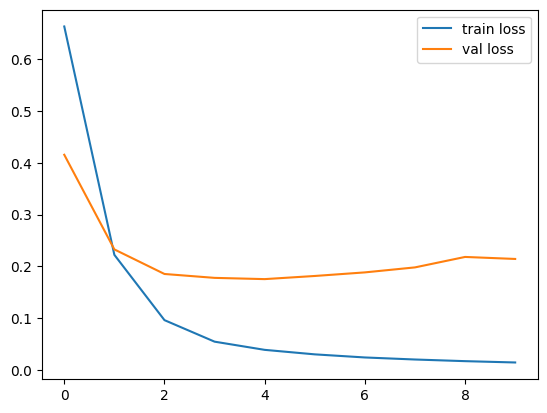

In [26]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

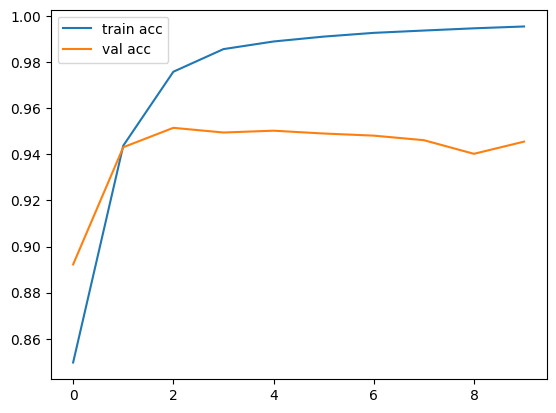

In [27]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

In [28]:
# True model accuracy - above includes padding

# first get length of each sequence
train_lengths = []
for sentence in train_inputs:
  train_lengths.append(len(sentence))

test_lengths = []
for sentence in test_inputs:
  test_lengths.append(len(sentence))


In [29]:
train_probs = model.predict(train_inputs_int) # N x T x K
train_predictions = []
for probs, length in zip(train_probs, train_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  train_predictions.append(preds)

# flatten
flat_train_predictions = flatten_list(train_predictions)
flat_train_targets = flatten_list(train_targets_int_unpadded)

398/398 [==============================] - 8s 16ms/step


In [30]:
test_probs = model.predict(test_inputs_int) # N x T x K
test_predictions = []
for probs, length in zip(test_probs, test_lengths):
  # probs is T x K
  probs_ = probs[-length:]
  preds = np.argmax(probs_, axis=1)
  test_predictions.append(preds)

# flatten
flat_test_predictions = flatten_list(test_predictions)
flat_test_targets = flatten_list(test_targets_int_unpadded)

93/93 [==============================] - 2s 17ms/step


In [31]:
from sklearn.metrics import accuracy_score, f1_score

print("Train acc:", accuracy_score(flat_train_targets, flat_train_predictions))
print("Test acc:", accuracy_score(flat_test_targets, flat_test_predictions))

print("Train f1:", f1_score(flat_train_targets, flat_train_predictions, average='macro'))
print("Test f1:", f1_score(flat_test_targets, flat_test_predictions, average='macro'))


Train acc: 0.9965156274852871
Test acc: 0.9455300391601236
Train f1: 0.9813743302308084
Test f1: 0.7869842676814862
